## Banking Insurance Product – Phase 2

## Import Libraries

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Understand correlation and association
from dython.nominal import associations
import dtale


# Standardize the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Model and performance evaluation
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

# Display settings
pd.set_option('display.max_rows', 99999)
pd.set_option('display.max_columns', 99999)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.act_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

## To clear the figs
import matplotlib
matplotlib.get_cachedir()

'C:\\Users\\krish\\.matplotlib'

##  Read Data and EDA

In [ ]:
# read the data
df = pd.read_csv("insurance_t.csv")

In [ ]:
# view the random five observations 
df.sample(n=5)

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,TELLER,SAV,SAVBAL,ATM,ATMAMT,POS,POSAMT,CD,CDBAL,IRA,IRABAL,INV,INVBAL,MM,MMBAL,MMCRED,CC,CCBAL,CCPURC,SDB,INCOME,LORES,HMVAL,AGE,CRSCORE,INAREA,INS,BRANCH
6029,3.4,1,1228.62,3,653.16,6,0,0,0.0,NaN,1,0,0.00,1,511.78,NaN,NaN,0,0,0,0.0,NaN,NaN,0,0.0,0,NaN,NaN,NaN,0,104.0,7.5,142.0,38.0,683.0,1,0,B19
5238,4.3,1,11.19,2,146.53,0,0,0,0.0,0.0,0,0,0.00,1,253.67,0.0,0.00,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.00,0.0,0,8.0,8.5,97.0,48.0,643.0,1,0,B8
5838,3.2,1,143.51,3,586.01,2,0,0,0.0,0.0,1,0,0.00,1,591.38,1.0,51.18,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.00,0.0,0,NaN,NaN,NaN,NaN,648.0,1,0,B2
1108,2.0,0,0.00,0,0.00,0,0,0,0.0,0.0,0,0,0.00,0,0.00,0.0,0.00,0,0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.00,0.0,0,9.0,10.0,86.0,61.0,703.0,1,1,B6
2236,0.6,1,1452.54,1,377.02,0,0,0,0.0,0.0,0,1,2686.98,1,97.03,0.0,0.00,1,48000,0,0.0,0.0,0.0,0,0.0,0,1.0,6739.68,0.0,0,60.0,7.0,130.0,43.0,673.0,1,1,B5


In [ ]:
# total size of the dataframe
df.shape

(8495, 38)

In [ ]:
# EDA - Before Imputation
dtale.show(df)

In [ ]:
# converting variables to float if number of unique observations is greater than 10
morethan10unique = df.loc[:, (df.nunique() > 10)].columns.tolist()
morethan10unique.remove('BRANCH')
for column in morethan10unique:
    df[column] = df[column].astype(np.float32)

In [ ]:
# Missing data
def missing_data(data):
    missing = data.isna().sum()
    percent_missing = (data.isna().sum()/data.isna().count()*100)   
    total_count = data.count()
    temp = pd.concat([total_count,missing, percent_missing], axis=1, keys=['Total','Missing', 'Missing(%)'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    temp['Types'] = types
    temp.sort_values('Missing(%)',ascending=False ,inplace=True)
    temp.reset_index(inplace=True)
    temp.rename(columns={'index':'column_name'}, inplace=True)
    temp = temp[temp.Missing != 0]
    
    return(temp)

In [ ]:
missing_data(df)

,column_name,Total,Missing,Missing(%),Types
0,AGE,6793,1702,20.035315,float32
1,HMVAL,6958,1537,18.092996,float32
2,LORES,6958,1537,18.092996,float32
3,INCOME,6958,1537,18.092996,float32
4,INVBAL,7420,1075,12.654503,float32
5,CCBAL,7420,1075,12.654503,float32
6,POSAMT,7420,1075,12.654503,float32
7,POS,7420,1075,12.654503,float32
8,CC,7420,1075,12.654503,float64
9,PHONE,7420,1075,12.654503,float32


In [ ]:
# filling the missing data with median (Only numerical variable found)
for cols in missing_data(df)["column_name"].tolist():
    df[cols]=df[cols].fillna(df[cols].median())

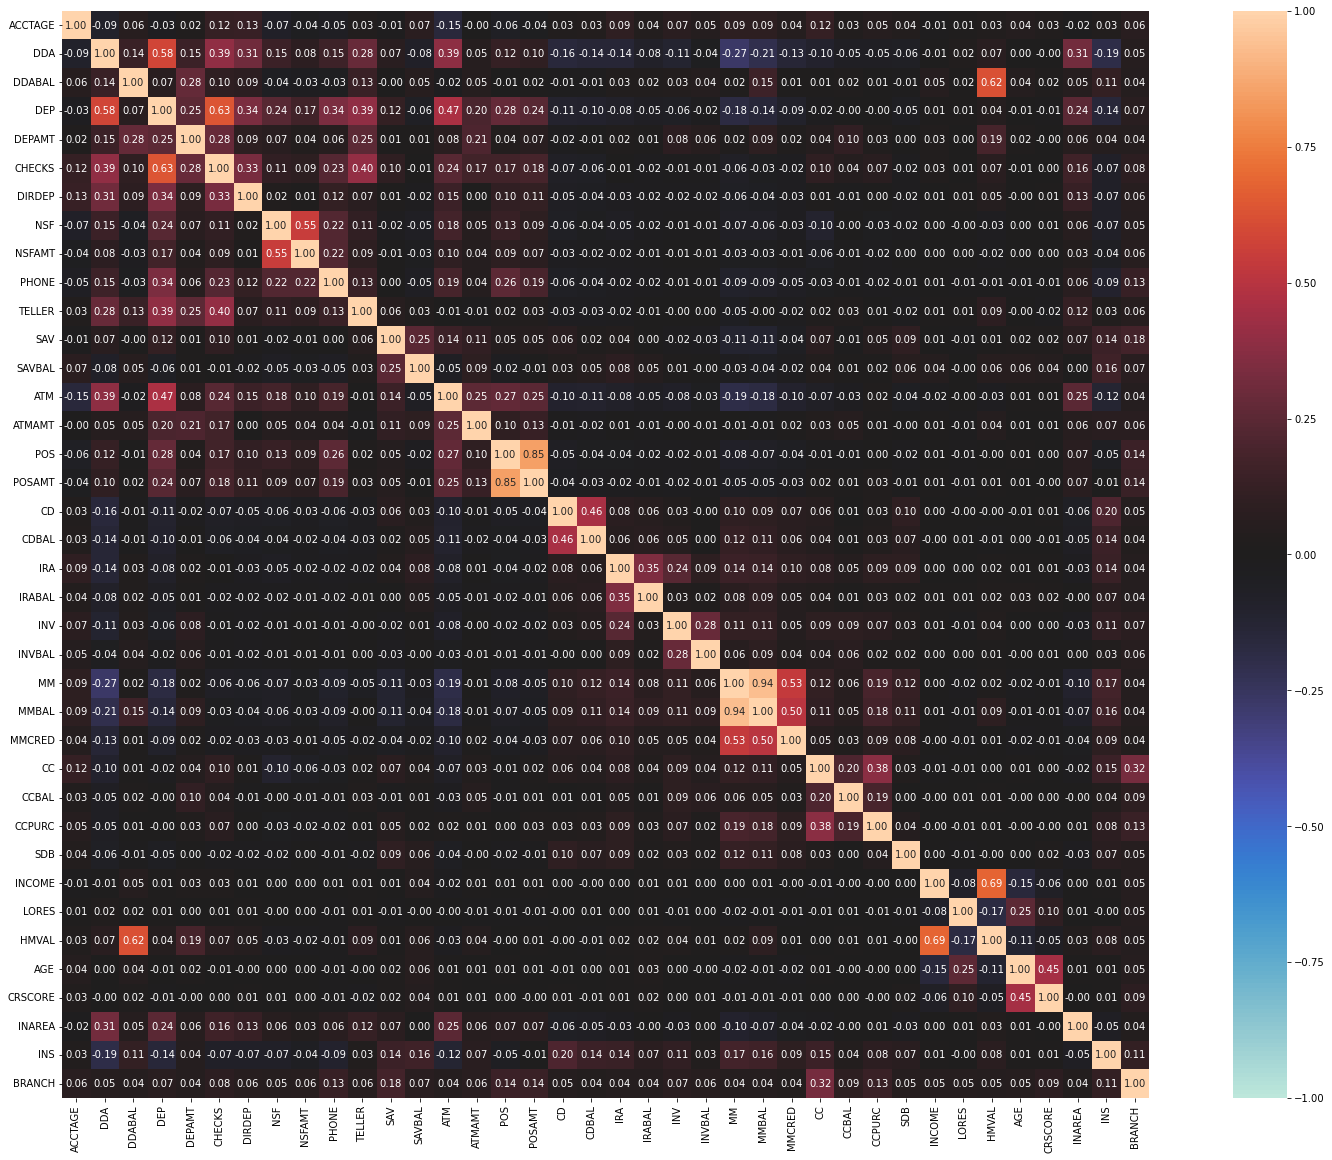

In [ ]:
# association - After Imputation
fig, ax = plt.subplots(figsize=(30, 20))
r = associations(df, ax = ax)

In [ ]:
# proportion on target variable
df.INS.value_counts(normalize=True)

0    0.656504
1    0.343496
Name: INS, dtype: float64

In [ ]:
# dummy code the object variable
branch_dummy = pd.get_dummies(df['BRANCH'],drop_first=True)
df = pd.concat([df,branch_dummy],axis=1)

In [ ]:
# drop the high correlation(greater than 0.85) variables and dummy encoded main variable 
df.drop(['BRANCH','POSAMT','MMBAL'],axis=1,inplace=True)

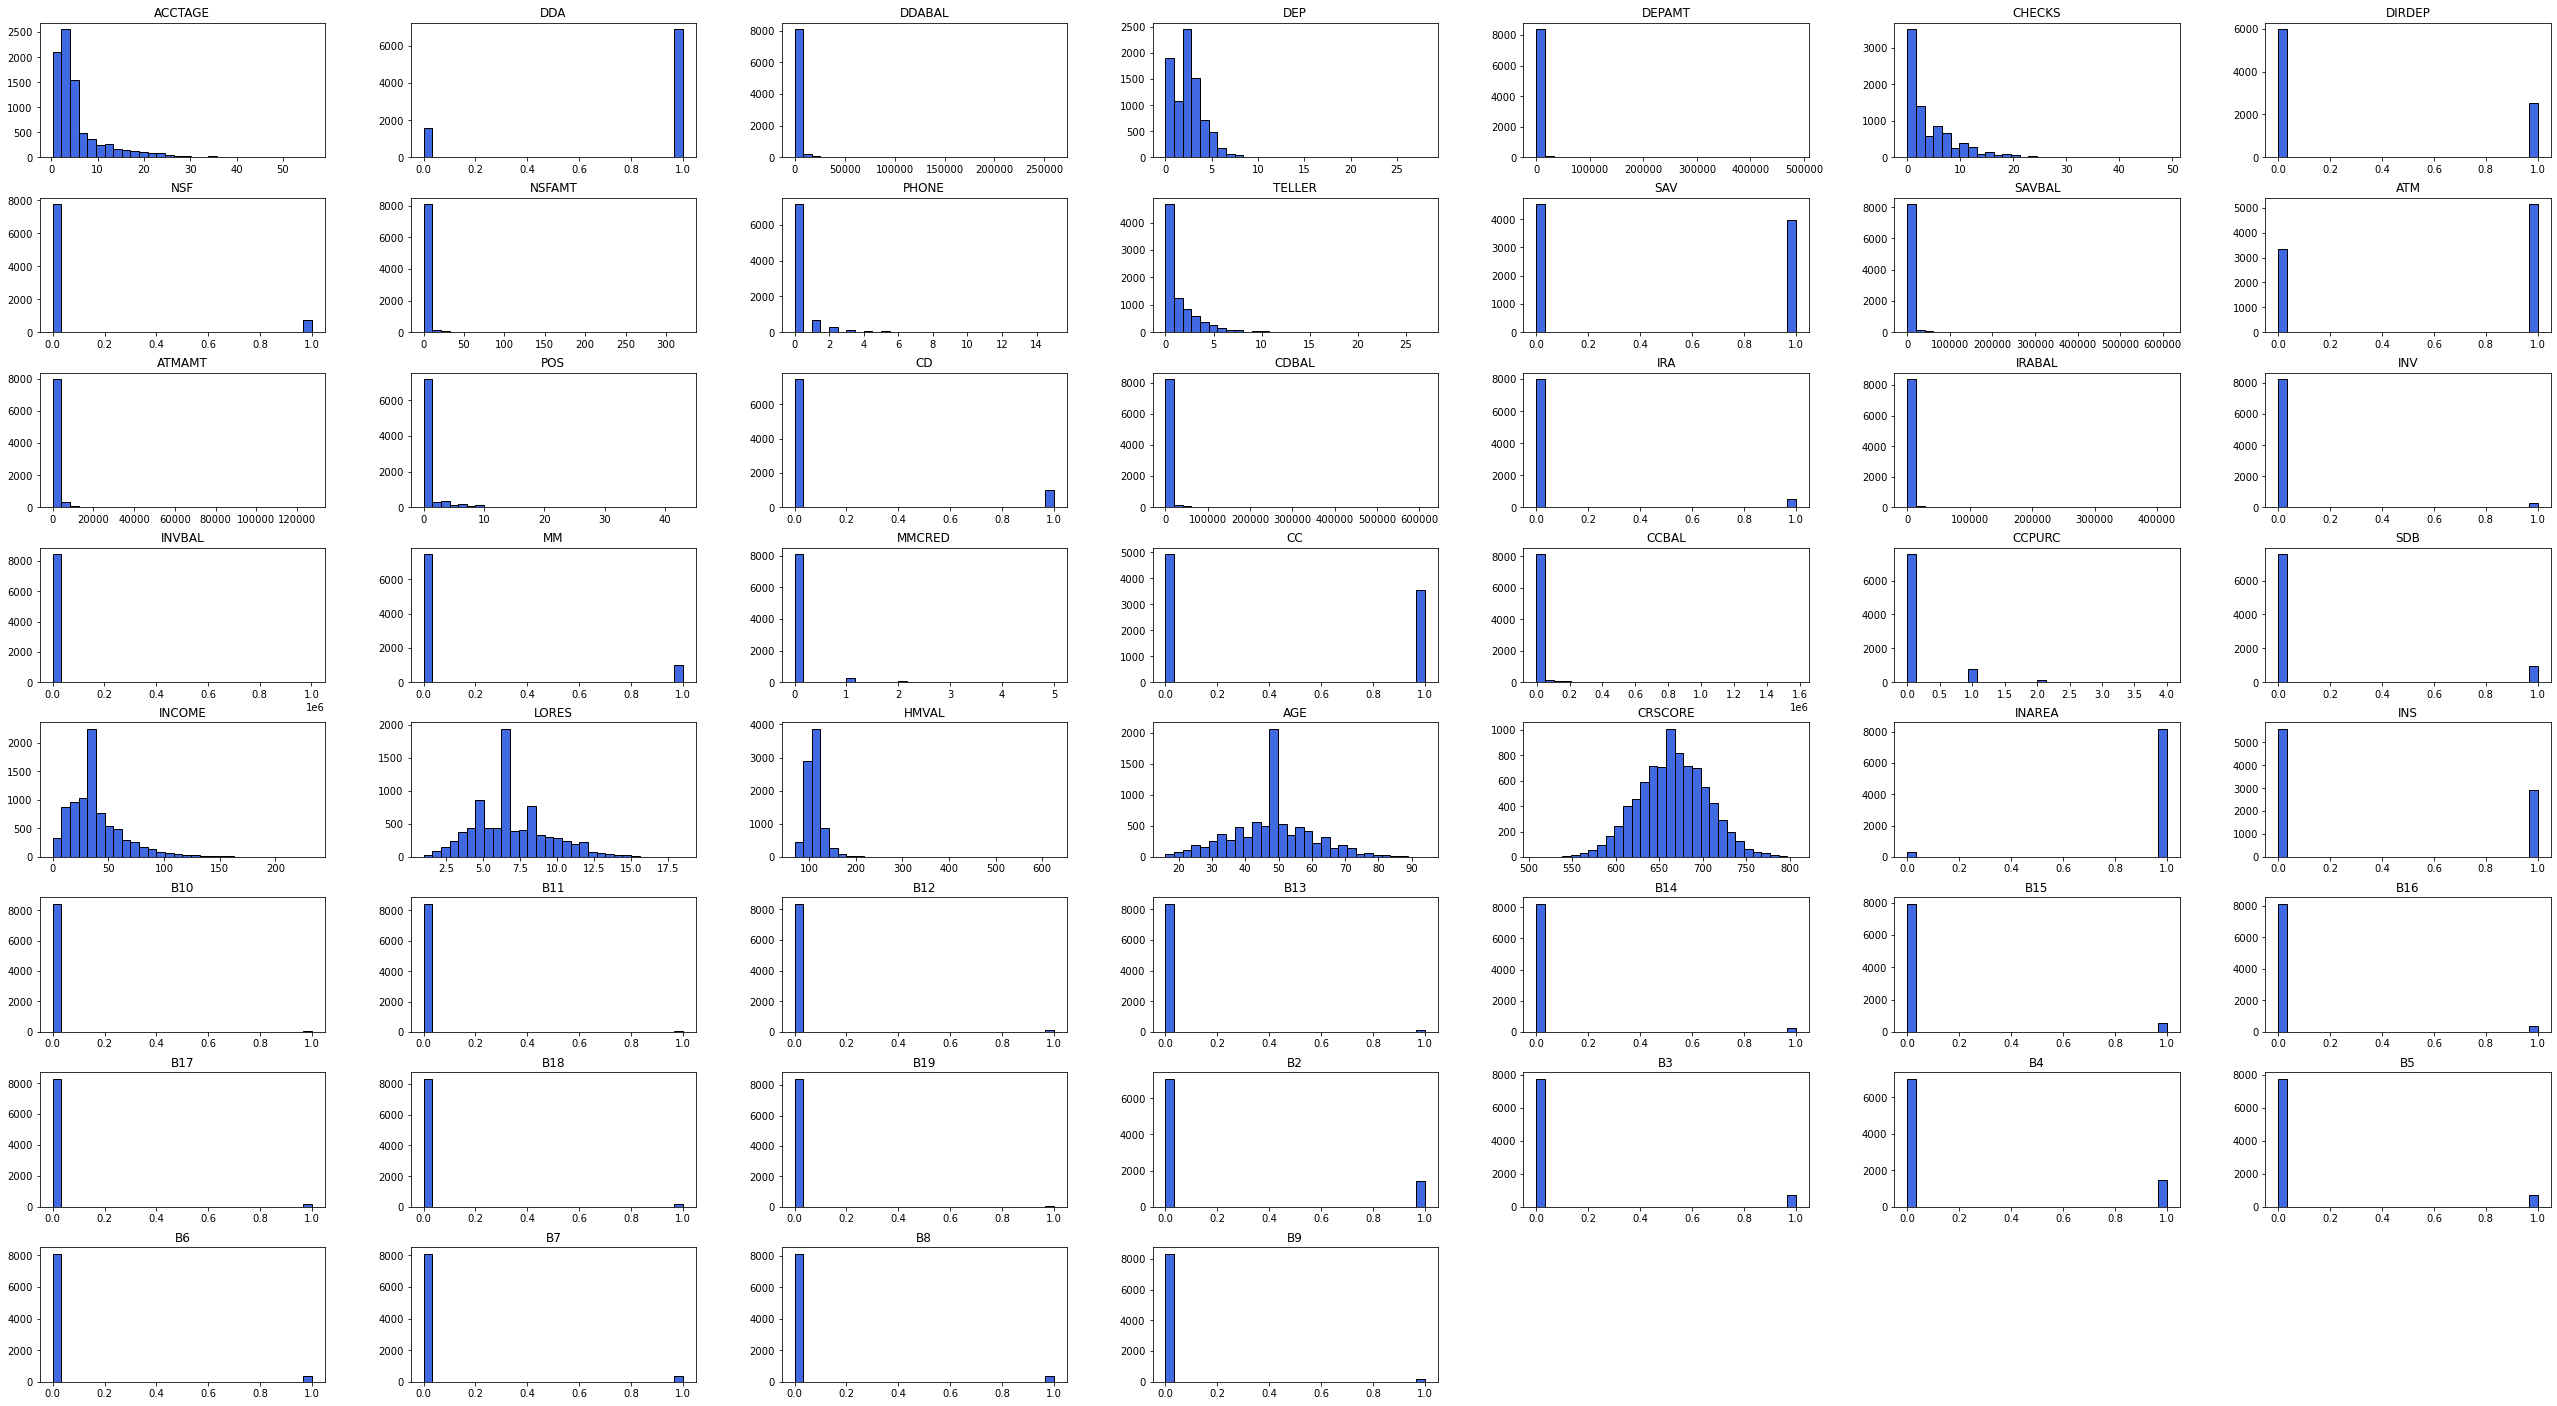

In [ ]:
# Univeriate - Numerical

def UnivNum(df):
    if df.select_dtypes(include='number').shape[1] <= 10:
        df.select_dtypes(include='number').hist(figsize=(10,5),bins=30,edgecolor='black',grid=False,color='royalblue')
        plt.show();
    else:
        df.select_dtypes(include='number').hist(figsize=(45,25),bins=30,edgecolor='black',grid=False,color='royalblue')
        plt.show();
        
UnivNum(df)

### Spilt the data - X's and y

In [ ]:
# adding a random normal distribution variable to the existing dataset
np.random.seed(42)
df['randNumCol'] = np.random.normal(0,1,df.shape[0]) # np.random.normal(mean,sd,#observation)

In [ ]:
X_train = df[df.columns.difference(['INS'])] # All independent variables
y_train = df['INS'] # Dependent/Target variable

### Random Forest

**RadomCV**

In [ ]:
# perform Random Cross Validation
n_estimators = [50,100,200,500,1000] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 240, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [10,15,20] # minimum sample number to split a node
min_samples_leaf = [1, 3, 4] # minimum sample number that can be stored in a leaf node
bootstrap = [True] # method used to sample data points
oob_score = [True] # out-of-bag samples to estimate the generalization error. Only available if bootstrap=True.

random_grid = {'n_estimators': n_estimators,
'max_features': max_features,
'max_depth': max_depth,
'min_samples_split': min_samples_split,
'min_samples_leaf': min_samples_leaf,
'bootstrap': bootstrap,
'oob_score': oob_score}

In [ ]:
# run the RCV
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
               n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [ ]:
%%time
# fit to the model to identify the best parameters
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: total: 6.91 s
Wall time: 8min 56s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True],
                                        'max_depth': [10, 30, 51, 72, 93, 114,
                                                      135, 156, 177, 198, 219,
                                                      240],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [10, 15, 20],
                                        'n_estimators': [50, 100, 200, 500,
                                                         1000],
                                        'oob_score': [True]},
                   random_state=35, verbose=2)

In [ ]:
# print the random parameters provided
print ('Random grid: ', random_grid, '\n')
# print the best parameters
print ('Best Parameters: ', rf_random.best_params_, ' \n')

Random grid:  {'n_estimators': [50, 100, 200, 500, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 30, 51, 72, 93, 114, 135, 156, 177, 198, 219, 240], 'min_samples_split': [10, 15, 20], 'min_samples_leaf': [1, 3, 4], 'bootstrap': [True], 'oob_score': [True]} 

Best Parameters:  {'oob_score': True, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 72, 'bootstrap': True}  



In [ ]:
# re-train the model with the best parameter obtained
randmf = RandomForestClassifier(n_estimators = 200, min_samples_split = 10, min_samples_leaf= 1, max_features = 'sqrt', 
                                max_depth= 72, bootstrap=True,oob_score=True) 
randmf.fit(X_train, y_train)

RandomForestClassifier(max_depth=72, max_features='sqrt', min_samples_split=10,
                       n_estimators=200, oob_score=True)

In [ ]:
# roc-auc score
roc_auc_score(y_train, randmf.predict(X_train))

0.9414422460897918

In [ ]:
# out of bag score
randmf.oob_score_

0.7396115361977634

2022-11-17 04:58:23,339 - WARNING  - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


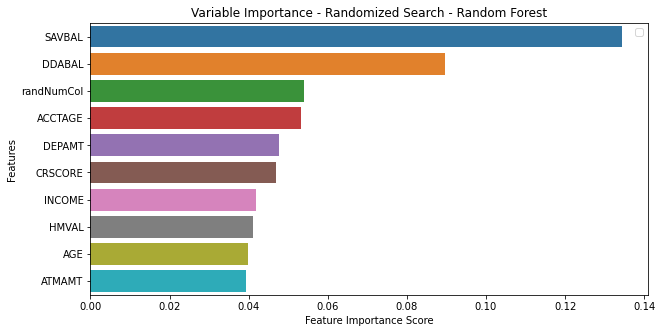

In [ ]:
# identify the top 10 important variable
feature_imp = pd.Series(randmf.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(10, 5))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index,ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Variable Importance - Randomized Search - Random Forest")
plt.legend()
# plt.savefig('VarImp_RandomizedSearch_RF.pdf',bbox_inches='tight')
plt.show()

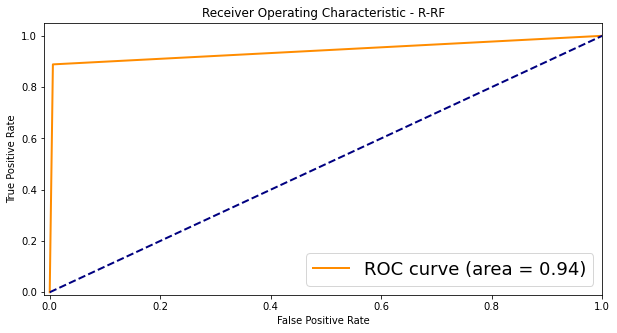

In [ ]:
# ROC-AUC curve
false_positive_rate_rfr, true_positive_rate_rfr, threshold_rfr = roc_curve(y_train, randmf.predict(X_train))
plt.subplots(figsize=(10, 5))
plt.title('Receiver Operating Characteristic - R-RF')
plt.plot(false_positive_rate_rfr, true_positive_rate_rfr,
        label="ROC curve (area = %0.2f)" % roc_auc_score(y_train, randmf.predict(X_train)),lw=2,color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right",fontsize=18)
plt.show()

**GridSearchCV**

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'oob_score': [True],
    'bootstrap': [True],
    'max_depth': [100,150,200],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,3,4,5,6],
    'min_samples_split': [5,10,15],
    'n_estimators': [100,200,500,1000,1200]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 225 candidates, totalling 675 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [100, 150, 200],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 3, 4, 5, 6],
                         'min_samples_split': [5, 10, 15],
                         'n_estimators': [100, 200, 500, 1000, 1200],
                         'oob_score': [True]},
             verbose=2)

In [ ]:
# print the gridsearchcv parameters provided
print ('Grid search: ', param_grid, '\n')
# print the best parameters
print ('Best Parameters Grid search: ', grid_search.best_params_, ' \n')

Grid search:  {'oob_score': [True], 'bootstrap': [True], 'max_depth': [100, 150, 200], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 3, 4, 5, 6], 'min_samples_split': [5, 10, 15], 'n_estimators': [100, 200, 500, 1000, 1200]} 

Best Parameters Grid search:  {'bootstrap': True, 'max_depth': 200, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 15, 'n_estimators': 1000, 'oob_score': True}  



In [ ]:
# re-train the model with the best parameter obtained
gridmf = RandomForestClassifier(n_estimators = 1000, min_samples_split = 15, min_samples_leaf= 3, max_features = 'sqrt',
                                bootstrap=True,oob_score=True,max_depth=200) 
gridmf.fit( X_train, y_train)

RandomForestClassifier(max_depth=200, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=15, n_estimators=1000, oob_score=True)

In [ ]:
# roc-auc score
roc_auc_score(y_train, gridmf.predict(X_train))

0.8751922889503951

In [ ]:
# out of bag score
gridmf.oob_score_

0.7451442024720424

2022-11-17 04:58:07,479 - WARNING  - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


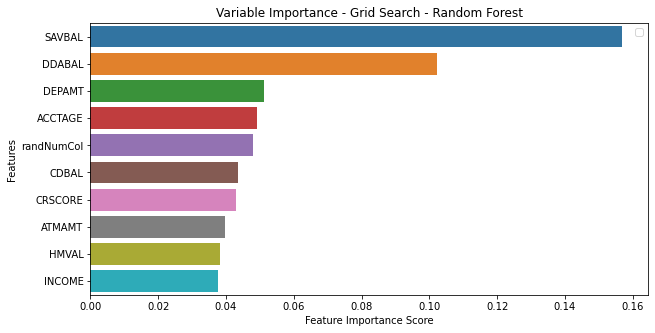

In [ ]:
# top 10 important variables
feature_imp = pd.Series(gridmf.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(10, 5))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index,ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Variable Importance - Grid Search - Random Forest")
plt.legend()
# plt.savefig('VarImp_GridSearch_RF.pdf',bbox_inches='tight')
plt.show()

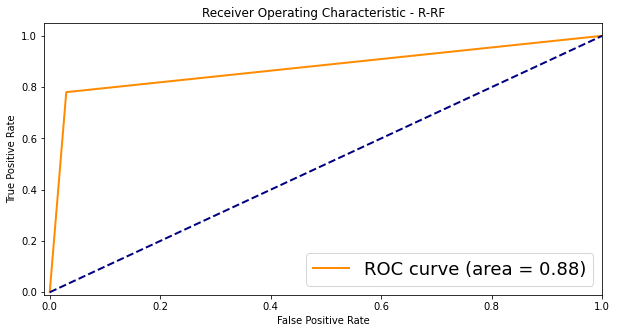

In [ ]:
# ROC-AUC curve
false_positive_rate_rfg, true_positive_rate_rfg, threshold_rfg = roc_curve(y_train, gridmf.predict(X_train))
plt.subplots(figsize=(10, 5))
plt.title('Receiver Operating Characteristic - R-RF')
plt.plot(false_positive_rate_rfg, true_positive_rate_rfg,
        label="ROC curve (area = %0.2f)" % roc_auc_score(y_train, gridmf.predict(X_train)),lw=2,color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right",fontsize=18)
plt.show()

### XGBoost

**Random Search**

In [ ]:
# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": [200,250,300],
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10],
    # eval_metric provides the evaluation metrics for validation data
    "eval_metric":['auc']}

# Set up score
scoring = ['roc_auc']

In [ ]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgboost, 
                           param_distributions=param_grid, 
                           n_iter=48,
                           scoring=scoring, 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=0)

# Fit grid search
random_result = random_search.fit(X_train, y_train)

# Print grid search summary
random_result

In [ ]:
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is 0.7981
The best hyperparameters are {'reg_lambda': 10, 'reg_alpha': 10, 'max_depth': 200, 'learning_rate': 0.1, 'gamma': 0.2, 'eval_metric': 'auc', 'colsample_bytree': 0.7}


In [ ]:
gridxg = XGBClassifier(reg_lambda = 10, reg_alpha = 10, max_depth= 200, learning_rate = 0.1, eval_metric='auc',
                                gamma=0.2,colsample_bytree=0.7) 
gridxg.fit(X_train, y_train)

In [ ]:
roc_auc_score(y_train, gridxg.predict(X_train))

0.8497178512600033

In [ ]:
feature_imp = pd.Series(gridxg.feature_importances_,index=X_train.columns).sort_values(ascending=False).head(10)
fig, ax = plt.subplots(figsize=(10, 5))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index,ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Variable Importance - Randomized Search - XGBoost")
plt.legend()
# plt.savefig('VarImp_RandomSearch_XGB.pdf',bbox_inches='tight')
plt.show()

In [ ]:
false_positive_rate_rxgb, true_positive_rate_rxgb, threshold_rxgb = roc_curve(y_train, gridxg.predict(X_train))
plt.subplots(figsize=(10, 5))
plt.title('ROC - Randomized Search CV - XGB')
plt.plot(false_positive_rate_rxgb, true_positive_rate_rxgb,
        label="ROC curve (area = %0.2f)" % roc_auc_score(y_train, gridxg.predict(X_train)),lw=2,color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right",fontsize=18)
# plt.savefig('ROC_XGB_RandomizedSearchCV.pdf',bbox_inches='tight')
plt.show()

**GridSearchCV**

In [ ]:
# Define the search space
param_grid = { 
    'learning_rate': [0.1],
    'max_depth': [200,250,300],
    'gamma': [0.1,0.15],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.7, 0.75 ,0.8],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [2,5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [2,5],
    "eval_metric":['auc']
    }

# Set up score
scoring = ['roc_auc']

In [ ]:
%%time
# Define grid search
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='roc_auc', 
                           n_jobs=-1, 
                           cv=5, 
                           verbose=0)

# Fit grid search
grid_result = grid_search.fit(X_train, y_train)

# Print grid search summary
grid_result

In [ ]:
# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.7947
The best hyperparameters are {'colsample_bytree': 0.8, 'eval_metric': 'auc', 'gamma': 0.15, 'learning_rate': 0.1, 'max_depth': 200, 'reg_alpha': 5, 'reg_lambda': 5}


In [ ]:
gridxgs = XGBClassifier(gamma = 0.15, learning_rate=0.1, max_depth=200,reg_lambda = 5, reg_alpha = 5,colsample_bytree=0.8)
gridxgs.fit(X_train, y_train)

In [ ]:
roc_auc_score(y_train, gridxgs.predict(X_train))

0.9324566972719025

In [ ]:
feature_imp = pd.Series(gridxgs.feature_importances_,index=X_train.columns).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10, 25))
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index,ax=ax)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
# plt.savefig('VarImp_XGB_93.pdf',bbox_inches='tight')
plt.show()

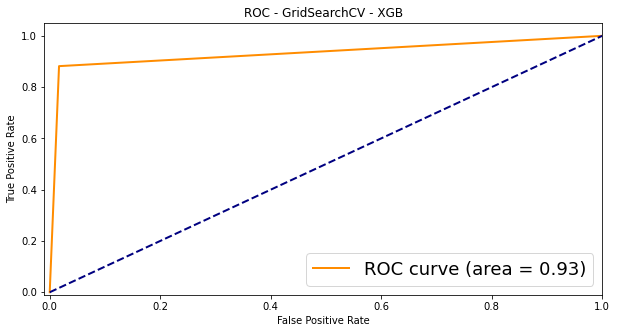

In [ ]:
false_positive_rate_rxgbs, true_positive_rate_rxgbs, threshold_rxgbs = roc_curve(y_train, gridxgs.predict(X_train))
plt.subplots(figsize=(10, 5))
plt.title('ROC - GridSearchCV - XGB')
plt.plot(false_positive_rate_rxgbs, true_positive_rate_rxgbs,
        label="ROC curve (area = %0.2f)" % roc_auc_score(y_train, gridxgs.predict(X_train)),lw=2,color="darkorange")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right",fontsize=18)
# plt.savefig('ROC_XGB_GridSearchCV.pdf',bbox_inches='tight')
plt.show()